In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
bin_path_cnn_random = "/gdrive/MyDrive/PPNCKH/saved/SST2/cnn_random.pt"
bin_path_cnn_fasttext_static = "/gdrive/MyDrive/PPNCKH/saved/SST2/cnn_fasttext_static.pt"
bin_path_cnn_fasttext_random = "/gdrive/MyDrive/PPNCKH/saved/SST2/cnn_fasttext_random.pt"

# fastText embedding path
fastText_path = "/gdrive/MyDrive/PPNCKH/bin/crawl-300d-2M.vec"

In [3]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.autograd import Variable

In [4]:
import os
import re
import nltk
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [5]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


# Download dataset

In [6]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 30.2 MB/s eta 0:00:00


In [7]:
from datasets import load_dataset, DatasetDict

In [8]:
train_dataset = load_dataset("sst2", split = "train")
test_dataset = load_dataset("sst2", split = "validation")

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset sst2 downloaded and prepared to /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5. Subsequent calls will reuse this data.


In [9]:
texts, labels = [item["sentence"] for item in train_dataset], [item["label"] for item in train_dataset]

In [10]:
label_list = list(set([item["label"] for item in train_dataset]))

In [11]:
from nltk.tokenize import word_tokenize
from collections import defaultdict
import numpy as np

In [12]:
def tokenize(texts):
    """Tokenize texts, build vocabulary and find maximum sentence length.
    
    Args:
        texts (List[str]): List of text data
    
    Returns:
        tokenized_texts (List[List[str]]): List of list of tokens
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

In [13]:
def encode(tokenized_texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our CNN model.
    """

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

Load pretrained vectors

In [14]:
from tqdm import tqdm_notebook

In [15]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [16]:
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)

# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, fastText_path)
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


<ipython-input-15-2bb33a43fea0>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):


0it [00:00, ?it/s]

There are 13951 / 14806 pretrained vectors found.


# Create dataloader

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [18]:
def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Specify batch_size
    batch_size = 50

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=42, stratify = labels)

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = \
data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

# Model

In [21]:
# Sample configuration:
filter_sizes = [2, 3, 4]
num_filters = [2, 2, 2]

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [23]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=num_classes,
                        dropout=dropout)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer


In [24]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

## Training

In [ ]:
# CNN-rand: Word vectors are randomly initialized.
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5,
                                      num_classes=len(label_list))
train(cnn_rand, optimizer, train_dataloader, val_dataloader, epochs=20)

# Save model
torch.save(cnn_rand.state_dict(), bin_path_cnn_random)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.560598   |  0.425847  |   80.86   |   14.54  
   2    |   0.377679   |  0.321785  |   86.06   |   7.24   
   3    |   0.285375   |  0.283485  |   87.81   |   7.19   
   4    |   0.234857   |  0.264880  |   89.25   |   7.27   
   5    |   0.203756   |  0.257541  |   89.83   |   7.30   
   6    |   0.178833   |  0.262954  |   89.99   |   7.21   
   7    |   0.161548   |  0.261641  |   90.47   |   11.09  
   8    |   0.146006   |  0.267437  |   90.56   |   11.78  
   9    |   0.135956   |  0.278038  |   90.43   |   7.40   
  10    |   0.129285   |  0.282195  |   90.39   |   7.40   
  11    |   0.119058   |  0.288175  |   90.84   |   7.12   
  12    |   0.111889   |  0.291186  |   90.94   |   7.41   
  13    |   0.106756   |  0.296335  |   90.90   |   7.10   
  14    |   0.102080   |  0.306967  |   91.10   |   7.36   
  15    |   0.094932

In [ ]:
# CNN-static: fastText pretrained word vectors are used and freezed during training.
set_seed(42)
cnn_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.25,
                                        dropout=0.5,
                                        num_classes=len(label_list))
train(cnn_static, optimizer, train_dataloader, val_dataloader, epochs=20)

# Save model
torch.save(cnn_static.state_dict(), bin_path_cnn_fasttext_static)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.346466   |  0.258617  |   89.96   |   4.08   
   2    |   0.244665   |  0.216108  |   91.96   |   4.48   
   3    |   0.196914   |  0.193937  |   93.09   |   4.97   
   4    |   0.169189   |  0.193270  |   92.86   |   4.09   
   5    |   0.145400   |  0.182936  |   93.55   |   4.45   
   6    |   0.132911   |  0.183690  |   93.64   |   3.82   
   7    |   0.120705   |  0.186376  |   93.80   |   3.82   
   8    |   0.113569   |  0.192689  |   93.51   |   4.70   
   9    |   0.105220   |  0.191927  |   93.71   |   3.77   
  10    |   0.101364   |  0.192314  |   94.00   |   3.79   
  11    |   0.093943   |  0.203570  |   93.83   |   4.65   
  12    |   0.090091   |  0.196928  |   94.02   |   4.04   
  13    |   0.086341   |  0.202906  |   93.88   |   4.82   
  14    |   0.082633   |  0.207683  |   93.98   |   4.57   
  15    |   0.081330

In [ ]:
# CNN-non-static: fastText pretrained word vectors are fine-tuned during training.
set_seed(42)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5,
                                            num_classes=len(label_list))
train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=20)

# Save model
torch.save(cnn_non_static.state_dict(), bin_path_cnn_fasttext_random)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.337680   |  0.245763  |   90.46   |   10.88  
   2    |   0.227579   |  0.202595  |   92.48   |   10.80  
   3    |   0.180712   |  0.184890  |   93.31   |   10.82  
   4    |   0.152203   |  0.179384  |   93.42   |   10.88  
   5    |   0.129517   |  0.176556  |   93.73   |   11.42  
   6    |   0.117022   |  0.179072  |   93.73   |   19.31  
   7    |   0.106306   |  0.182434  |   94.14   |   13.88  
   8    |   0.097130   |  0.189744  |   93.88   |   11.21  
   9    |   0.088374   |  0.187677  |   94.05   |   10.71  
  10    |   0.086308   |  0.192474  |   93.94   |   10.79  
  11    |   0.077593   |  0.202954  |   93.89   |   10.77  
  12    |   0.074250   |  0.201916  |   94.01   |   10.77  
  13    |   0.070728   |  0.207934  |   94.06   |   10.85  
  14    |   0.067828   |  0.218632  |   94.07   |   10.67  
  15    |   0.066152

# Evaluation

In [25]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [27]:
# CNN-rand: Word vectors are randomly initialized.
set_seed(42)
cnn_rand, _ = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5,
                                      num_classes=len(label_list))

# Save model
cnn_rand.load_state_dict(torch.load(bin_path_cnn_random, map_location=torch.device('cpu')))

<All keys matched successfully>

In [28]:
# CNN-static: fastText pretrained word vectors are used and freezed during training.
set_seed(42)
cnn_static, _ = initilize_model(pretrained_embedding=embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.25,
                                        dropout=0.5,
                                        num_classes=len(label_list))

# Save model
cnn_static.load_state_dict(torch.load(bin_path_cnn_fasttext_static, map_location=torch.device('cpu')))

<All keys matched successfully>

In [29]:
# CNN-non-static: fastText pretrained word vectors are fine-tuned during training.
set_seed(42)
cnn_non_static, _ = initilize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5,
                                            num_classes=len(label_list))

# Save model
cnn_non_static.load_state_dict(torch.load(bin_path_cnn_fasttext_random, map_location=torch.device('cpu')))

<All keys matched successfully>

In [30]:
count_parameters(cnn_rand)

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
|   embedding.weight   |  4441800   |
| conv1d_list.0.weight |   90000    |
|  conv1d_list.0.bias  |    100     |
| conv1d_list.1.weight |   120000   |
|  conv1d_list.1.bias  |    100     |
| conv1d_list.2.weight |   150000   |
|  conv1d_list.2.bias  |    100     |
|      fc.weight       |    600     |
|       fc.bias        |     2      |
+----------------------+------------+
Total Trainable Params: 4802702


4802702

In [31]:
count_parameters(cnn_static)

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
| conv1d_list.0.weight |   90000    |
|  conv1d_list.0.bias  |    100     |
| conv1d_list.1.weight |   120000   |
|  conv1d_list.1.bias  |    100     |
| conv1d_list.2.weight |   150000   |
|  conv1d_list.2.bias  |    100     |
|      fc.weight       |    600     |
|       fc.bias        |     2      |
+----------------------+------------+
Total Trainable Params: 360902


360902

In [32]:
count_parameters(cnn_non_static)

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
|   embedding.weight   |  4441800   |
| conv1d_list.0.weight |   90000    |
|  conv1d_list.0.bias  |    100     |
| conv1d_list.1.weight |   120000   |
|  conv1d_list.1.bias  |    100     |
| conv1d_list.2.weight |   150000   |
|  conv1d_list.2.bias  |    100     |
|      fc.weight       |    600     |
|       fc.bias        |     2      |
+----------------------+------------+
Total Trainable Params: 4802702


4802702

In [ ]:
def predict(text, model, max_len = 62):
    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = torch.argmax(F.softmax(logits, dim=1).squeeze(dim=0))

    return probs.item()

In [ ]:
# predict(test[0][1]["text"])

In [ ]:
def eval_testset(model):
    correct_label = []
    predicted_label = []
    
    for item in test_dataset:
        correct_label.append(item["label"])
        predicted_label.append(predict(item["sentence"], model))
    
    return predicted_label, correct_label

## Evaluate for cnn_rand

In [ ]:
y_pred_cnn_rand, y_true_cnn_rand = eval_testset(cnn_rand.to("cpu"))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
print(classification_report(y_true_cnn_rand, y_pred_cnn_rand))

              precision    recall  f1-score   support

           0       0.83      0.64      0.72       428
           1       0.72      0.87      0.79       444

    accuracy                           0.76       872
   macro avg       0.77      0.76      0.76       872
weighted avg       0.77      0.76      0.76       872



In [ ]:
print(f"Accuracy: {accuracy_score(y_true_cnn_rand, y_pred_cnn_rand):.6f} | \
        Precision: {precision_score(y_true_cnn_rand, y_pred_cnn_rand, average = 'macro'):.6f} | \
        Recall: {recall_score(y_true_cnn_rand, y_pred_cnn_rand, average = 'macro'):.6f} | \
        F1 score: {f1_score(y_true_cnn_rand, y_pred_cnn_rand, average = 'macro'):.6f}")

Accuracy: 0.760321 |         Precision: 0.774003 |         Recall: 0.758199 |         F1 score: 0.756227


In [ ]:
print(confusion_matrix(y_true_cnn_rand, y_pred_cnn_rand))

[[275 153]
 [ 56 388]]


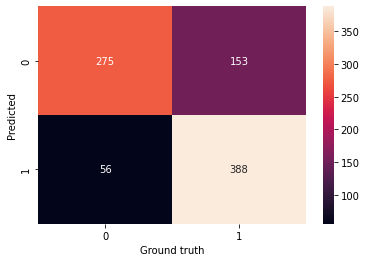

In [ ]:
sns.heatmap(confusion_matrix(y_true_cnn_rand, y_pred_cnn_rand), annot = True, fmt = "g")
plt.ylabel("Predicted")
plt.xlabel("Ground truth")
plt.show()

In [ ]:
for text, pred, truth in zip(test_dataset["sentence"][0:10], y_pred_cnn_rand[0:10], y_true_cnn_rand[0:10]):
    print(f"{text} -- {pred} -- {truth}")

it 's a charming and often affecting journey .  -- 1 -- 1
unflinchingly bleak and desperate  -- 0 -- 0
allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker .  -- 1 -- 1
the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales .  -- 1 -- 1
it 's slow -- very , very slow .  -- 0 -- 0
although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women .  -- 1 -- 1
a sometimes tedious film .  -- 0 -- 0
or doing last year 's taxes with your ex-wife .  -- 1 -- 0
you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance .  -- 1 -- 1
in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey .  -- 0 -- 0


Inference time measuring

In [ ]:
from time import perf_counter

In [ ]:
predicted_timelapse = []

for item in test_dataset:
    start_time = perf_counter()
    predict(item["sentence"], model = cnn_rand)
    end_time = perf_counter()

    predicted_timelapse.append(end_time - start_time)

In [ ]:
timelapse_mean = np.mean(predicted_timelapse) * 1000
timelapse_std = np.std(predicted_timelapse) * 1000

In [ ]:
print(f"Mean: {timelapse_mean:.8f}, stdev: {timelapse_std:.8f} ms")

Mean: 2.37811245, stdev: 0.74728438 ms


## Evaluate for cnn_static

In [ ]:
y_pred_cnn_static, y_true_cnn_static = eval_testset(cnn_static.to("cpu"))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
print(classification_report(y_true_cnn_static, y_pred_cnn_static))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       428
           1       0.80      0.88      0.84       444

    accuracy                           0.83       872
   macro avg       0.83      0.83      0.83       872
weighted avg       0.83      0.83      0.83       872



In [ ]:
print(f"Accuracy: {accuracy_score(y_true_cnn_static, y_pred_cnn_static):.6f} | \
        Precision: {precision_score(y_true_cnn_static, y_pred_cnn_static, average = 'macro'):.6f} | \
        Recall: {recall_score(y_true_cnn_static, y_pred_cnn_static, average = 'macro'):.6f} | \
        F1 score: {f1_score(y_true_cnn_static, y_pred_cnn_static, average = 'macro'):.6f}")


Accuracy: 0.830275 |         Precision: 0.833611 |         Recall: 0.829334 |         F1 score: 0.829521


In [ ]:
print(confusion_matrix(y_true_cnn_static, y_pred_cnn_static))

[[333  95]
 [ 53 391]]


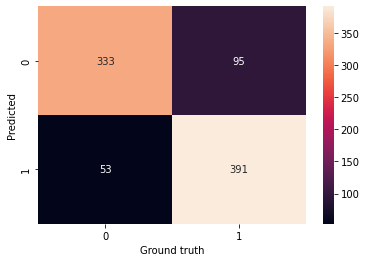

In [ ]:
sns.heatmap(confusion_matrix(y_true_cnn_static, y_pred_cnn_static), annot = True, fmt = "g")
plt.ylabel("Predicted")
plt.xlabel("Ground truth")
plt.show()

In [ ]:
for text, pred, truth in zip(test_dataset["sentence"][0:10], y_pred_cnn_static[0:10], y_true_cnn_static[0:10]):
    print(f"{text} -- {pred} -- {truth}")

it 's a charming and often affecting journey .  -- 1 -- 1
unflinchingly bleak and desperate  -- 0 -- 0
allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker .  -- 1 -- 1
the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales .  -- 1 -- 1
it 's slow -- very , very slow .  -- 0 -- 0
although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women .  -- 1 -- 1
a sometimes tedious film .  -- 0 -- 0
or doing last year 's taxes with your ex-wife .  -- 1 -- 0
you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance .  -- 1 -- 1
in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey .  -- 0 -- 0


Inference time measuring

In [ ]:
predicted_timelapse = []

for item in test_dataset:
    start_time = perf_counter()
    predict(item["sentence"], model = cnn_static)
    end_time = perf_counter()

    predicted_timelapse.append(end_time - start_time)

In [ ]:
timelapse_mean = np.mean(predicted_timelapse) * 1000
timelapse_std = np.std(predicted_timelapse) * 1000

In [ ]:
print(f"Mean: {timelapse_mean:.8f}, stdev: {timelapse_std:.8f} ms")

Mean: 1.70499101, stdev: 0.37919519 ms


## Evaluate for cnn_non_static

In [ ]:
y_pred_cnn_non_static, y_true_cnn_non_static = eval_testset(cnn_non_static.to("cpu"))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
print(classification_report(y_true_cnn_non_static, y_pred_cnn_non_static))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       428
           1       0.80      0.92      0.86       444

    accuracy                           0.84       872
   macro avg       0.85      0.84      0.84       872
weighted avg       0.85      0.84      0.84       872



In [ ]:
print(f"Accuracy: {accuracy_score(y_true_cnn_non_static, y_pred_cnn_non_static):.6f} | \
        Precision: {precision_score(y_true_cnn_non_static, y_pred_cnn_non_static, average = 'macro'):.6f} | \
        Recall: {recall_score(y_true_cnn_non_static, y_pred_cnn_non_static, average = 'macro'):.6f} | \
        F1 score: {f1_score(y_true_cnn_non_static, y_pred_cnn_non_static, average = 'macro'):.6f}")

Accuracy: 0.842890 |         Precision: 0.850696 |         Recall: 0.841511 |         F1 score: 0.841590


In [ ]:
print(confusion_matrix(y_true_cnn_non_static, y_pred_cnn_non_static))

[[328 100]
 [ 37 407]]


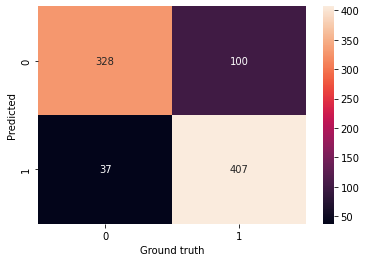

In [ ]:
sns.heatmap(confusion_matrix(y_true_cnn_non_static, y_pred_cnn_non_static), annot = True, fmt = "g")
plt.ylabel("Predicted")
plt.xlabel("Ground truth")
plt.show()

In [ ]:
for text, pred, truth in zip(test_dataset["sentence"][0:10], y_pred_cnn_non_static[0:10], y_true_cnn_non_static[0:10]):
    print(f"{text} -- {pred} -- {truth}")

it 's a charming and often affecting journey .  -- 1 -- 1
unflinchingly bleak and desperate  -- 0 -- 0
allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker .  -- 1 -- 1
the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales .  -- 1 -- 1
it 's slow -- very , very slow .  -- 0 -- 0
although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women .  -- 1 -- 1
a sometimes tedious film .  -- 0 -- 0
or doing last year 's taxes with your ex-wife .  -- 1 -- 0
you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance .  -- 1 -- 1
in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey .  -- 0 -- 0


Inference time measuring

In [ ]:
predicted_timelapse = []

for item in test_dataset:
    start_time = perf_counter()
    predict(item["sentence"], model = cnn_non_static)
    end_time = perf_counter()

    predicted_timelapse.append(end_time - start_time)

In [ ]:
timelapse_mean = np.mean(predicted_timelapse) * 1000
timelapse_std = np.std(predicted_timelapse) * 1000

In [ ]:
print(f"Mean: {timelapse_mean:.8f}, stdev: {timelapse_std:.8f} ms")

Mean: 1.77991550, stdev: 0.32949006 ms
